In [15]:
import matplotlib.pyplot as plt
import pandas 
import numpy
import re
import pickle
import backtest
import heapq

# Important Functions

In [71]:
def load_pkl_data(path_to_file):
  with open(path_to_file,"rb") as file:
    result = pickle.load(file, encoding='bytes')
    # print('read_goodlist:', result)
    return result

def save_as_pkl_data(result, path_to_file):
  with open(path_to_file,"wb") as file:
    pickle.dump(result, file)

def get_config_list_from_backtest_summary(backtest_summary):
  config_list = backtest_summary[['config_length', 'config_multiplier']]
  return config_list.values.tolist()


class GoodList():
  '''
  Store configurations and its associated profit as heapq
  '''
  def __init__(self, max_length=10):
    self.toplist = []
    self.count = 0
    self.max_length = max_length

  def push(self, value, content):
    '''
    Replace configuration associating with the smallest profit/balance with a better one (if there's any) 
    '''
    if len(self.toplist) < self.max_length:
      heapq.heappush(self.toplist, (value, content))
    elif value > heapq.nsmallest(1, self.toplist)[0][0]:
      heapq.heapreplace(self.toplist, (value, content))


def get_top10_length_riskAdjusted(df):
    # Length
    goodlist_length = GoodList()
    for length in range(4,21):
        balance = list(df[df['config_length'].values == length]['balance'])

        # Calculate risk-adjusted return for
        median_return = numpy.median(balance)
        std = numpy.std(balance)
        sharpe_ratio = median_return/std

        goodlist_length.push(sharpe_ratio, length)

    return goodlist_length

def get_top10_multiplier_riskAdjusted(df):
    # Length
    goodlist_multiplier = GoodList()
    for multiplier in range(4,21):
        balance = list(df[df['config_multiplier'].values == multiplier]['balance'])

        # Calculate risk-adjusted return 
        median_return = numpy.median(balance)
        std = numpy.std(balance)
        sharpe_ratio = median_return/std

        goodlist_multiplier.push(sharpe_ratio, multiplier)

    return goodlist_multiplier






def plot_balance_against_length_multiplier(df, coin_timeframe):
    df['balance_std'] = (df['balance'] - df['balance'].mean()) / df['balance'].std()

    # Plot balances distribution against Length and Multiplier 
    balance_for_lengths = []
    balance_for_multipliers = []
    
    # Length
    for length in range(4,21):
      balance_for_each_length = list(df[df['config_length'].values == length]['balance'])
      balance_for_lengths.append(balance_for_each_length)

    fig = plt.figure(figsize=[24, 8])
    ax = fig.add_subplot(1, 2, 1)
    ax.boxplot(balance_for_lengths);
    ax.set_xticklabels(range(4,21))
    ax.set_title('Balance vs. Length')

    # Multiplier
    for multiplier in numpy.arange(4,20.5,0.5):
      balance_for_each_multiplier = list(df[df['config_multiplier'].values == multiplier]['balance'])
      balance_for_multipliers.append(balance_for_each_multiplier)

    ax = fig.add_subplot(1, 2, 2)
    ax.boxplot(balance_for_multipliers);
    ax.set_xticklabels(numpy.arange(4,20.5,0.5))
    ax.set_title('Balance vs. Multiplier')

def plot_pnl_distribution_for_topConfigs(df, good_length, good_multiplier):
    '''
    Plot PnL histogram for TOP lengths and multipliers
    ''' 
    profit_amounts = []
    loss_amounts = []
    for multiplier in good_multiplier:
      for length in good_length:
        queried_df = df.copy().query(f"config_length=={length} & config_multiplier=={multiplier}")
        profit_amounts = profit_amounts + re.sub("\[|\]|\"|\s", "", queried_df.iloc[0].profit_amounts).split(',')
        loss_amounts = loss_amounts + re.sub("\[|\]|\"|\s", "", queried_df.iloc[0].loss_amounts).split(',')

    profit_amounts = [float(x) for x in profit_amounts]
    loss_amounts = [float(x) for x in loss_amounts]

    fig = plt.figure(figsize=[20, 14])
    ax = fig.add_subplot(2, 1, 1)
    ax.hist(profit_amounts, 101);
    # ax.set_xticks(range(0,600,20))  #
    ax.set_title('Profits distribution of Top Lengths')

    ax = fig.add_subplot(2, 1, 2)
    ax.hist(loss_amounts, 101);
    # ax.set_xticks(range(0,600,20))
    ax.set_title('Losses distribution of Top Multipliers')

def plot_pnl_distribution_for_bestConfig(df, best_length, best_multiplier):
    '''
    Plot PnL histogram just for best length and multiplier
    '''
    profit_amounts = []
    loss_amounts = []
    queried_df = df.query(f"config_length=={best_length} & config_multiplier=={best_multiplier}").copy()
    print(queried_df[['average_profit','average_loss']])
    # Convert strings to list
    profit_amounts = profit_amounts + re.sub("\[|\]|\"|\s", "", queried_df.iloc[0].profit_amounts).split(',')
    loss_amounts = loss_amounts + re.sub("\[|\]|\"|\s", "", queried_df.iloc[0].loss_amounts).split(',')
    # Convert int to float
    profit_amounts = [float(x) for x in profit_amounts]
    loss_amounts = [float(x) for x in loss_amounts]

    fig = plt.figure(figsize=[20, 14])
    ax = fig.add_subplot(2, 1, 1)
    ax.hist(profit_amounts, 101);
    # ax.set_xticks(range(0,600,20))  #
    ax.set_title('Profits distribution of The Best Length')

    ax = fig.add_subplot(2, 1, 2)
    ax.hist(loss_amounts, 101);
    # ax.set_xticks(range(0,600,20))
    ax.set_title('Losses distribution of The Best Multiplier')


## BTC 15m


top10_length:
[(4.153325457145662, 12), (4.300043133766206, 13), (4.437769258955183, 4), (4.543344079087885, 14), (4.517332357235451, 15), (5.410273113818118, 6), (4.7053870801902065, 10), (4.961321918938912, 7), (4.779495898508897, 5), (4.9163908159840455, 8)] 
top10_multiplier:
[(8.59151889642819, 13), (8.746311406304946, 8), (8.744912545617924, 15), (8.87718491422315, 11), (9.406682884449246, 20), (11.323074845947215, 9), (9.685234954745999, 10), (9.104044000771093, 16), (9.129300405628499, 14), (9.70529115418315, 17)]
best_length: 6 
best_multiplier: 9
    average_profit  average_loss
76       14.731464     -5.304726


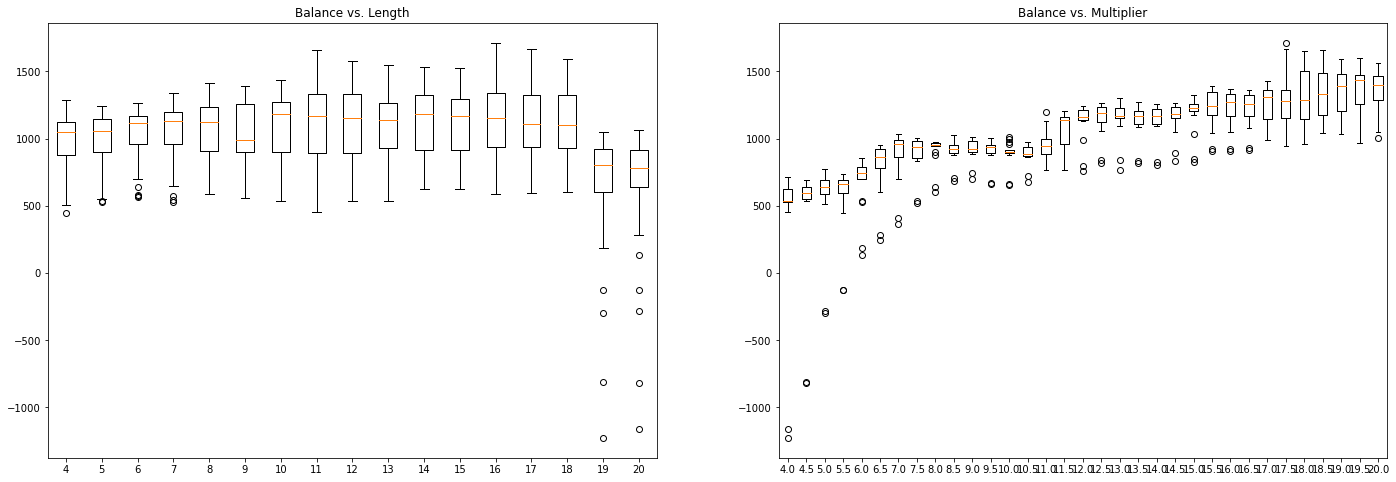

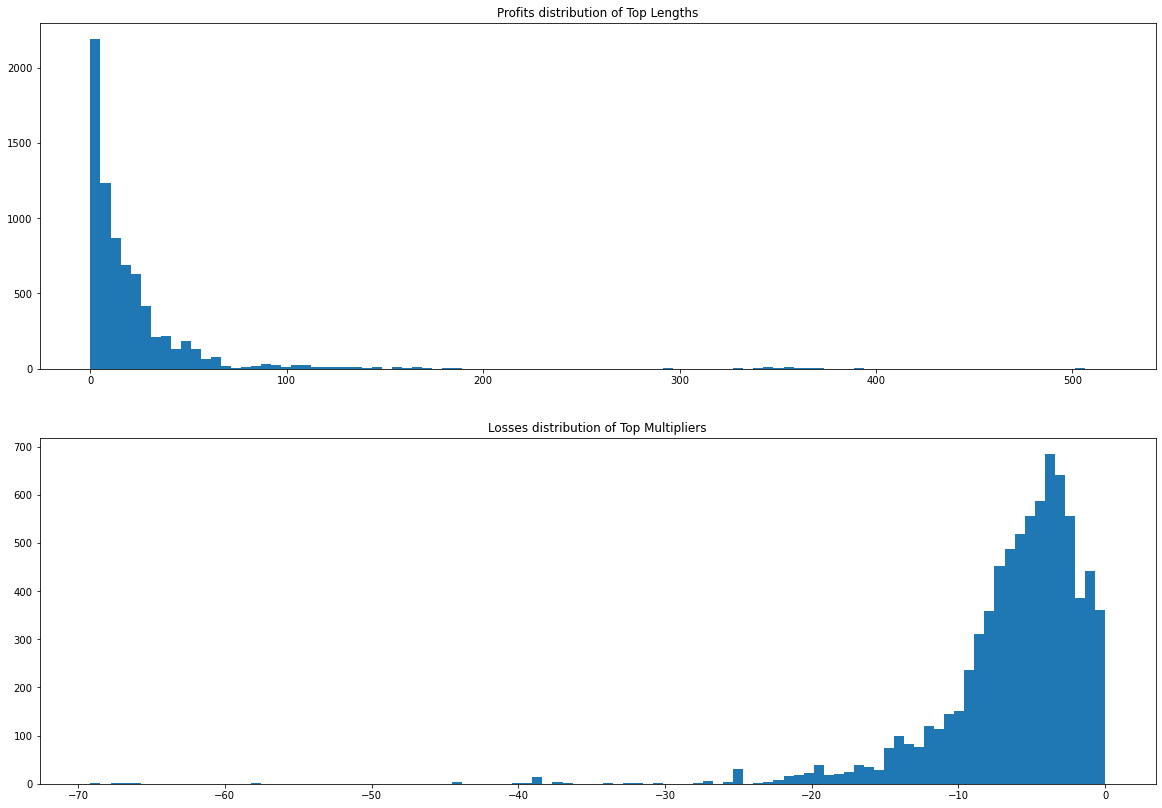

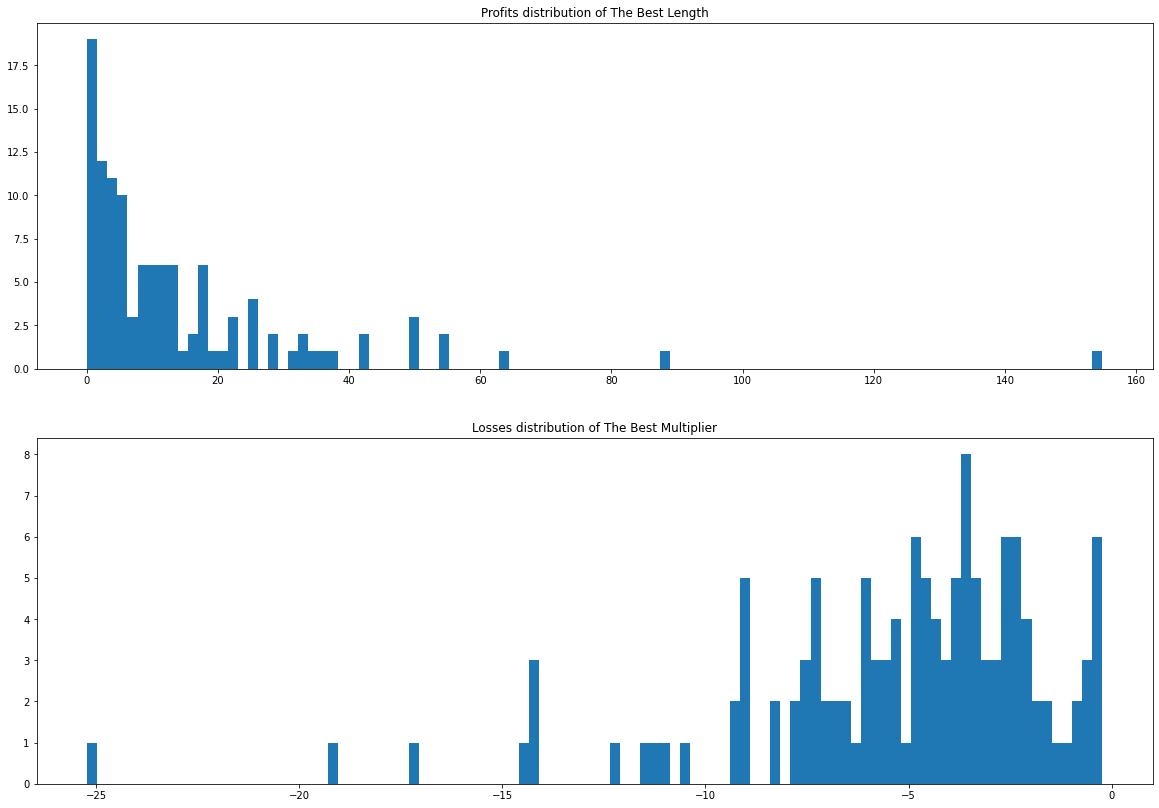

In [72]:
coin_timeframe = 'btc_15m'
df_btc15m = pandas.read_csv(f"individual_backtest/backtest_summary_{coin_timeframe}.csv")

top10_length = get_top10_length_riskAdjusted(df_btc15m).toplist
top10_multiplier = get_top10_multiplier_riskAdjusted(df_btc15m).toplist

good_length = [item[1] for item in top10_length]
good_multiplier = [item[1] for item in top10_multiplier]

best_length = heapq.nlargest(1, top10_length)[0][1]
best_multiplier = heapq.nlargest(1, top10_multiplier)[0][1]

print(f'top10_length:\n{top10_length} ')
print(f'top10_multiplier:\n{top10_multiplier}')
print(f'best_length: {best_length} ')
print(f'best_multiplier: {best_multiplier}')

plot_balance_against_length_multiplier(df_btc15m, coin_timeframe)
plot_pnl_distribution_for_topConfigs(df_btc15m, top10_length, top10_multiplier)
plot_pnl_distribution_for_bestConfig(df_btc15m, best_length, best_multiplier)

## BTC 1h

/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


top10_length:
[(1.2895165808063773, 10), (3.5081533243316945, 11), (1.3288990746693943, 9), (3.5903917608233678, 17), (3.709259862659718, 16), (3.835877260486139, 18), (4.187111586452514, 15), (4.023325076862547, 14), (3.6342281774913747, 12), (3.9231283393266105, 13)] 
top10_multiplier:
[(3.5553810227810776, 9), (3.605599387928912, 13), (3.949869143510915, 15), (3.6146001126542493, 18), (4.130128343148895, 16), (4.610218991791164, 20), (4.149619723411064, 10), (4.274243387659482, 17), (3.927189022710918, 14), (4.382934516851118, 19)]
     average_profit  average_loss
405       52.255505    -10.815636


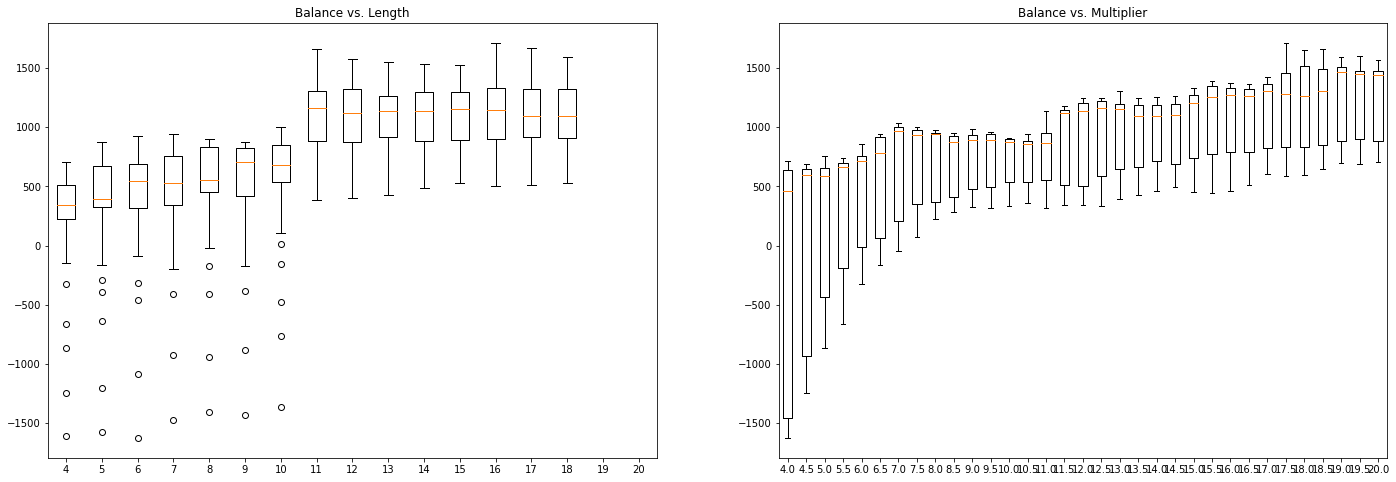

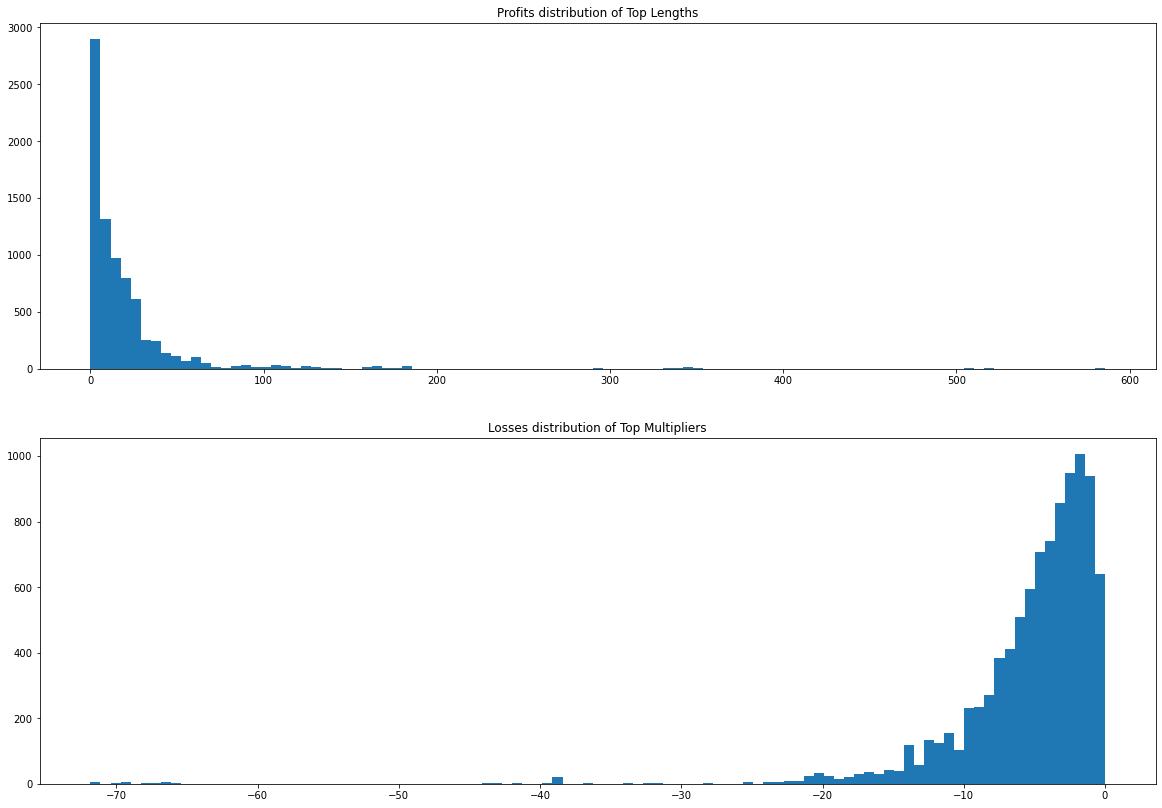

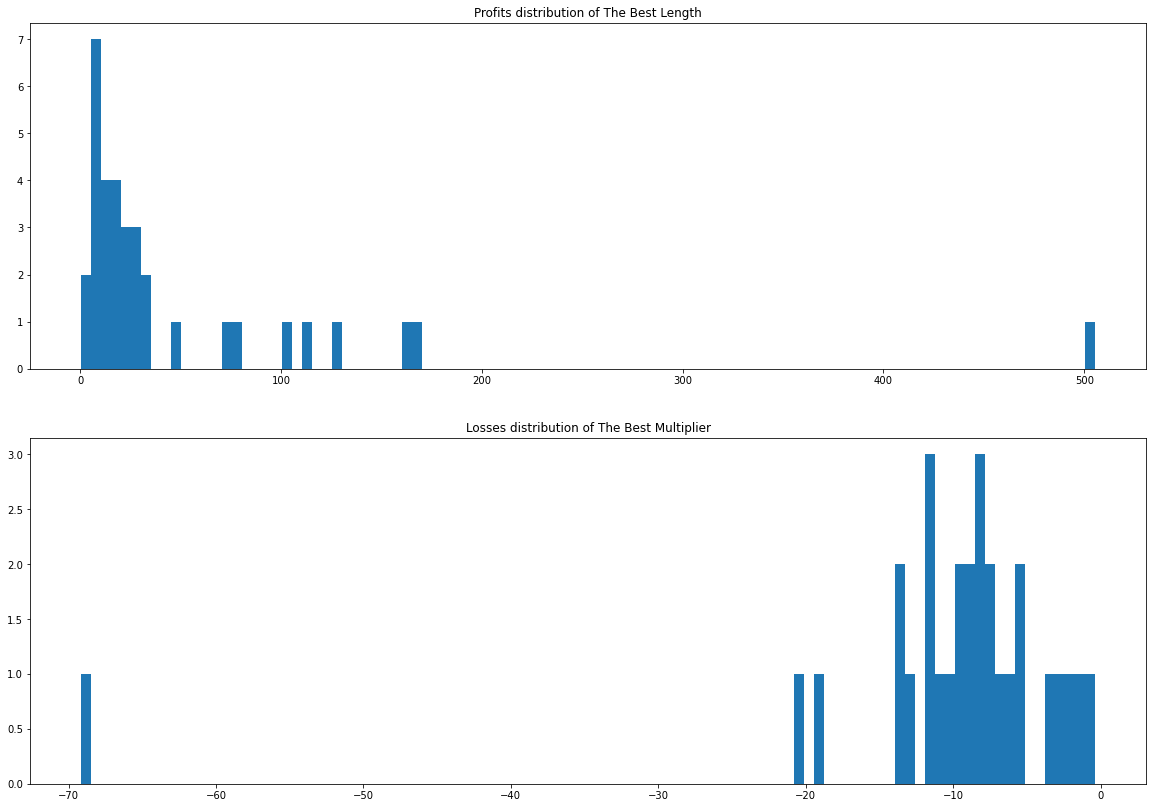

In [73]:
coin_timeframe = 'btc_1h'
df_btc1h = pandas.read_csv(f"individual_backtest/backtest_summary_{coin_timeframe}.csv")

top10_length = get_top10_length_riskAdjusted(df_btc1h).toplist
top10_multiplier = get_top10_multiplier_riskAdjusted(df_btc1h).toplist

good_length = [item[1] for item in top10_length]
good_multiplier = [item[1] for item in top10_multiplier]

best_length = heapq.nlargest(1, top10_length)[0][1]
best_multiplier = heapq.nlargest(1, top10_multiplier)[0][1]

print(f'top10_length:\n{top10_length} ')
print(f'top10_multiplier:\n{top10_multiplier}')

plot_balance_against_length_multiplier(df_btc1h, coin_timeframe)
plot_pnl_distribution_for_topConfigs(df_btc1h, top10_length, top10_multiplier)
plot_pnl_distribution_for_bestConfig(df_btc1h, best_length, best_multiplier)

## BTC 4h

/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


top10_length:
[(3.5481829607160025, 11), (3.6693580231459997, 17), (4.314620283506568, 9), (3.7841936979140987, 10), (3.7639224068628114, 18), (5.125313887356866, 5), (4.682938501005668, 6), (5.309951997604953, 4), (4.737288052258595, 7), (4.763178483292458, 8)] 
top10_multiplier:
[(7.904888676948256, 6), (8.273811960564593, 14), (9.24936092153557, 4), (12.886498010890229, 12), (8.606824257797324, 20), (32.21708780583903, 9), (16.523981471170064, 10), (44.85678747981555, 5), (15.16313794965005, 11), (9.662454830981215, 13)]
best_length: 4 
best_multiplier: 5
    average_profit  average_loss
43       29.751187     -6.240547


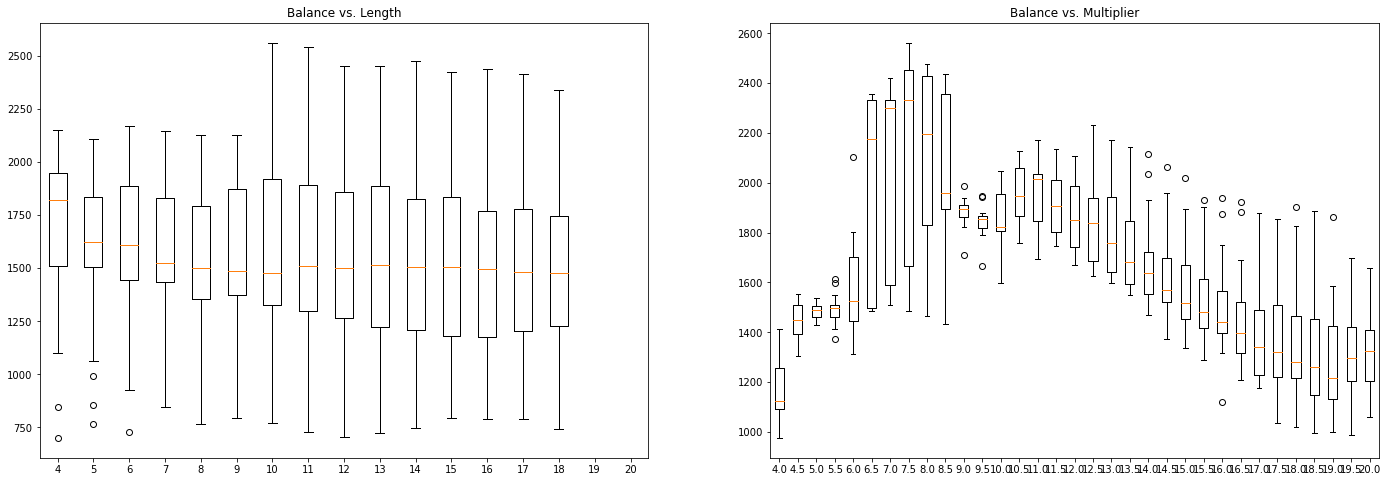

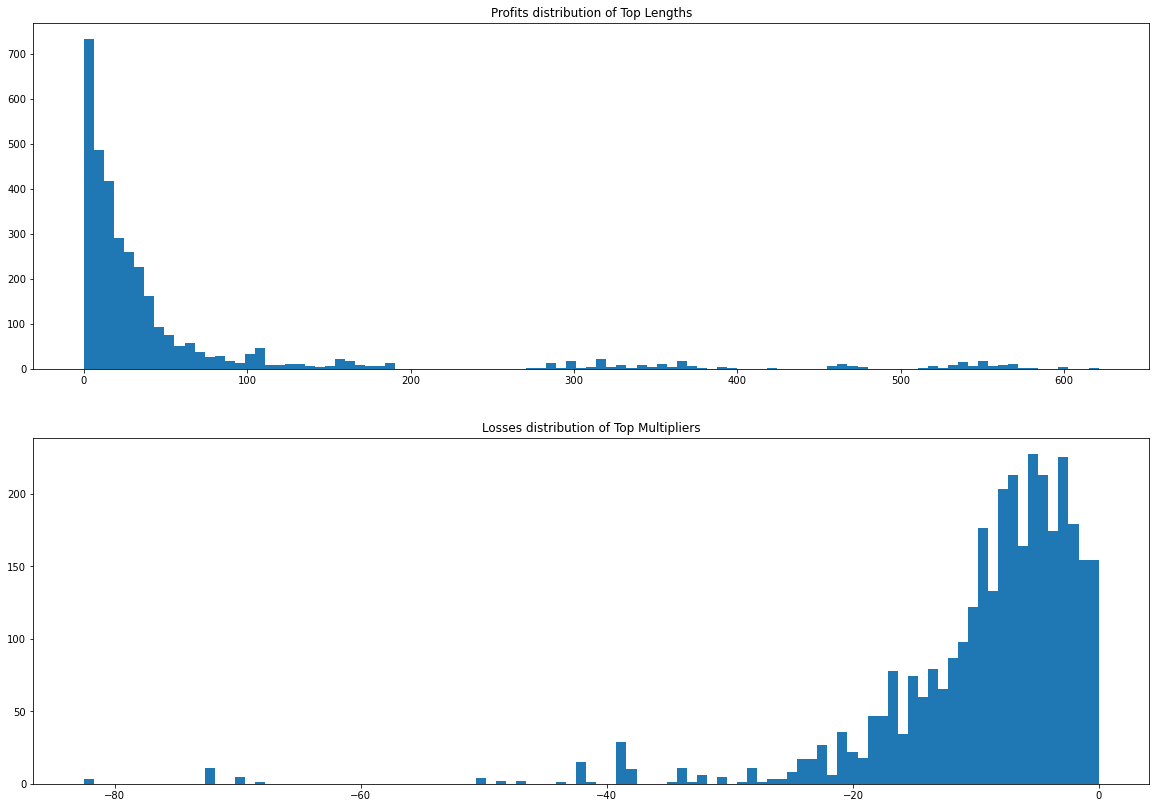

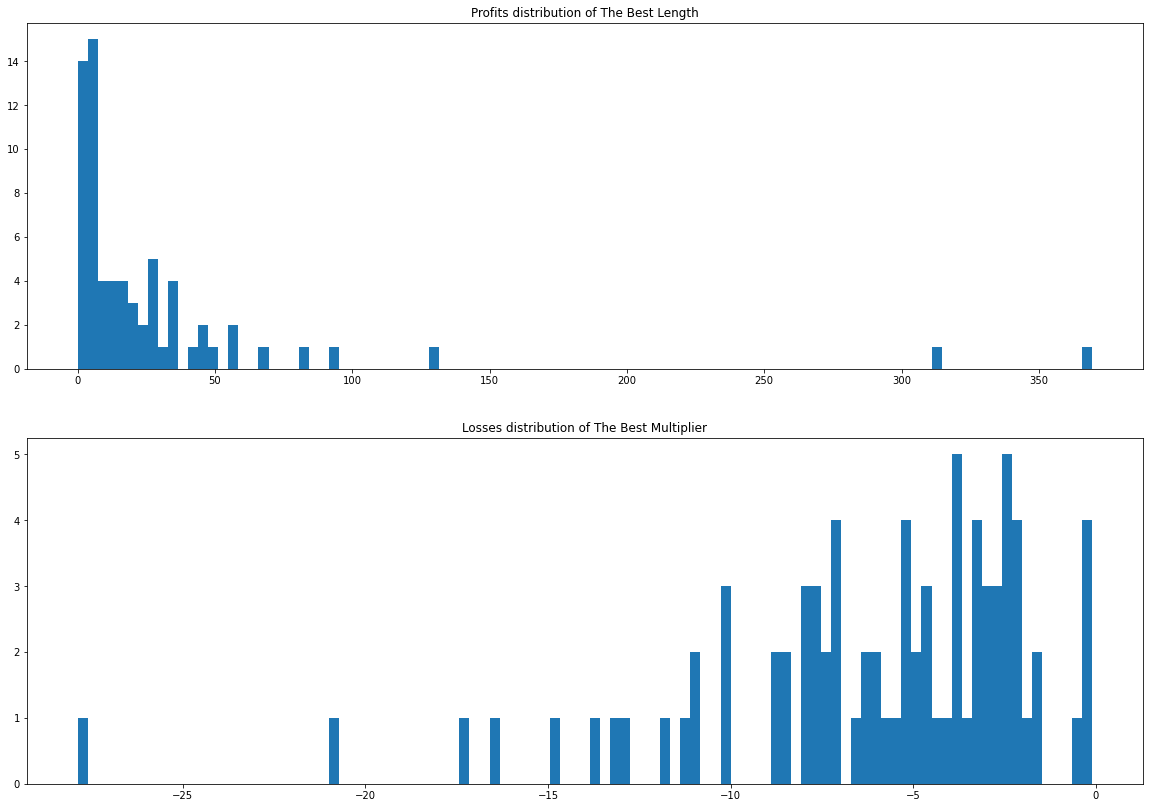

In [74]:
coin_timeframe = 'btc_4h'
df_btc4h = pandas.read_csv(f"individual_backtest/backtest_summary_{coin_timeframe}.csv")

top10_length = get_top10_length_riskAdjusted(df_btc4h).toplist
top10_multiplier = get_top10_multiplier_riskAdjusted(df_btc4h).toplist

good_length = [item[1] for item in top10_length]
good_multiplier = [item[1] for item in top10_multiplier]

best_length = heapq.nlargest(1, top10_length)[0][1]
best_multiplier = heapq.nlargest(1, top10_multiplier)[0][1]

print(f'top10_length:\n{top10_length} ')
print(f'top10_multiplier:\n{top10_multiplier}')
print(f'best_length: {best_length} ')
print(f'best_multiplier: {best_multiplier}')

plot_balance_against_length_multiplier(df_btc4h, coin_timeframe)
plot_pnl_distribution_for_topConfigs(df_btc4h, top10_length, top10_multiplier)
plot_pnl_distribution_for_bestConfig(df_btc4h, best_length, best_multiplier)



/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


goodlist_length: [ 4.  5.  6.  7.  8.  9. 10. 11. 18. 17.]
goodlist_multiplier: [4.  4.5 5.  5.5 6.  9.  7.  7.5 8.  8.5]
kinda_best_length = 4;	kinda_best_multiplier = 5.0
    average_profit  average_loss
43       29.751187     -6.240547


{'coin_timeframe': 'btc_4h',
 'kinda_best_length': 4,
 'kinda_best_multiplier': 5.0,
 'good_length_list': array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 18., 17.]),
 'good_multiplier_list': array([4. , 4.5, 5. , 5.5, 6. , 9. , 7. , 7.5, 8. , 8.5])}

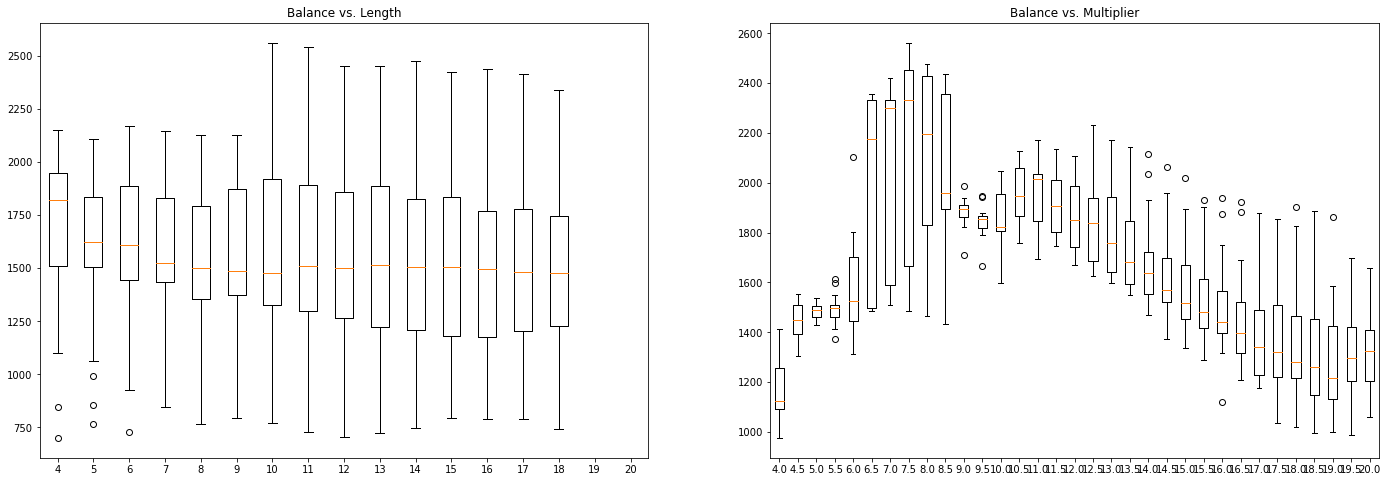

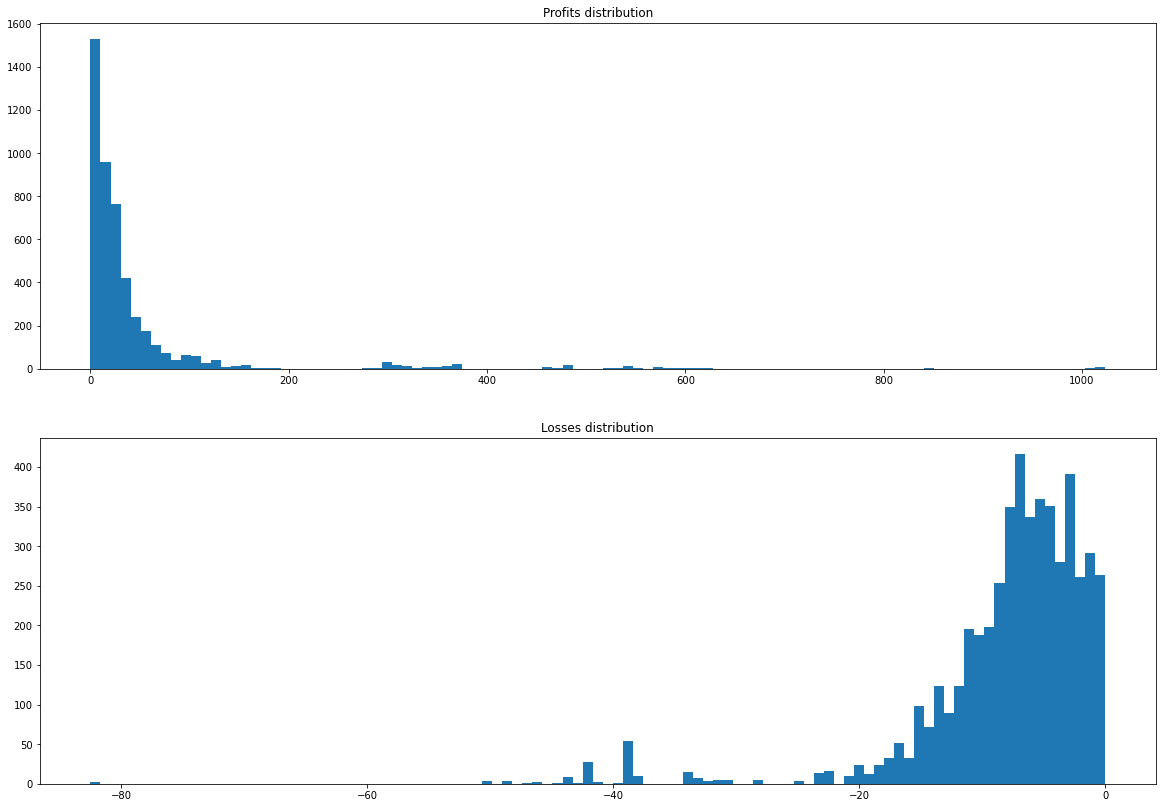

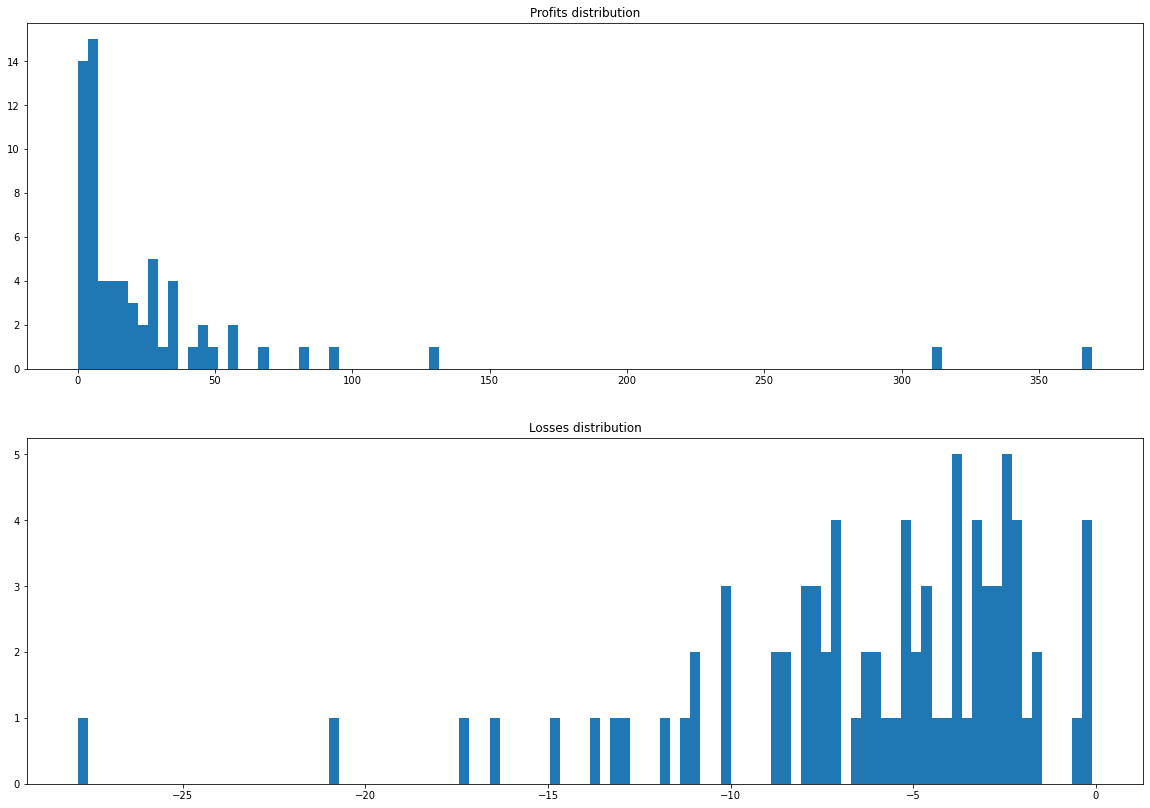

In [ ]:
#### OLD VERSION ####

# coin_timeframe = 'btc_4h'
# df_btc4h = pandas.read_csv(f"individual_backtest/backtest_summary_{coin_timeframe}.csv")
# result = plot1(df_btc4h, coin_timeframe)
# save_as_pkl_data(result, f"individual_backtest/goodlist_{coin_timeframe}.pkl")

# Get Best Configs 
whose returns are in top10 and whose length & multiplier are in the goodlist 

In [ ]:
coin_timeframes = [
  'btc_1h',
  'btc_4h',
  ]

for coin_timeframe in coin_timeframes:
  path = f"individual_backtest/goodlist_{coin_timeframe}.pkl"
  goodlist = load_pkl_data(path)

  backtest_summary = pandas.read_csv(f"individual_backtest/backtest_summary_{coin_timeframe}.csv")
  backtest_summary.sort_values(by='balance', ascending=False, inplace=True)
  # print(backtest_summary.head(10))
  backtest_summary = backtest_summary[  backtest_summary['config_length'].isin(goodlist['good_length_list']) & 
                                        backtest_summary['config_multiplier'].isin(goodlist['good_multiplier_list'])]
  backtest_summary = backtest_summary.iloc[:10,:]
  backtest_summary.to_csv(f"individual_backtest/best_configs_{coin_timeframe}.csv")
  
  config_list = get_config_list_from_backtest_summary(backtest_summary)
  print(config_list)
  save_as_pkl_data(config_list, f"individual_backtest/config_list_{coin_timeframe}.pkl")


[[7.0, 8.5], [13.0, 7.0], [7.0, 9.0], [6.0, 9.0], [13.0, 7.5], [5.0, 9.0], [7.0, 7.5], [14.0, 7.5], [14.0, 7.0], [8.0, 8.5]]
[[11.0, 19.5], [11.0, 19.0], [11.0, 20.0], [13.0, 19.0], [14.0, 19.0], [15.0, 19.0], [13.0, 19.5], [14.0, 19.5], [14.0, 20.0], [13.0, 20.0]]
[[10.0, 7.5], [11.0, 7.5], [11.0, 8.0], [11.0, 7.0], [17.0, 7.5], [17.0, 8.0], [10.0, 7.0], [18.0, 7.0], [18.0, 8.0], [17.0, 7.0]]


# Backtest the best configs in bear market and recent 3 years

In [ ]:


coin = 'btc'
timeframes = ('4h', '1h');  length_in_days = (1/6, 1/24, 1/24/4)
trends = ('_recentYear',)  #'_bear1', '_bear2', '_bear3', 
result_recorder = backtest.ResultRecorder()

for trend in trends:
  for timeframe, length_in_day in zip(timeframes, length_in_days):
    print('timeframe =', timeframe)
    config_list = load_pkl_data(f"individual_backtest/config_list_{coin}_{timeframe}.pkl")

    df = pandas.read_csv(f"historical_data/{coin}_{timeframe}_original{trend}.csv")
    # Rename columns and drop some to reduce memory weight
    df['timestamp'] = df['time_period_start']
    df['open'] = df['price_open']
    df['high'] = df['price_high']
    df['low'] = df['price_low']
    df['close'] = df['price_close']
    df.drop(['time_period_start', 'time_open', 
            'price_open', 'price_high', 'price_low', 
            'price_close', 'volume_traded', 'trades_count'], axis=1)
    df = df.iloc[::-1].reset_index()
    print('length_of_df =', len(df))

    for (length, multiplier) in config_list:
      length = int(length)
      print(f"config = ({length},{multiplier})")
      supertrend_data, balance = backtest.backtest(length, multiplier, result_recorder, df)
        
      result_recorder.add_new_row({
          'coinpair': coin,
          'timeframe': timeframe,
          'length_in_days': length_in_day*len(supertrend_data), 
          'trend': trend,
          'balance': balance, 
          'config_length': length, 
          'config_multiplier': multiplier, 
          'no_of_orders': result_recorder.order_number, 
          'number_of_profit_order': result_recorder.get_profit_order_number(), 
          'average_profit': result_recorder.get_average_profit(), 
          'number_of_loss_order': result_recorder.get_loss_order_number(), 
          'average_loss': result_recorder.get_average_loss(),
          'avarage_pnl_per_month': balance / (length_in_day*len(supertrend_data)) * 30,
          'profit_amounts': f"\"{result_recorder.get_profit_order()}\"",
          'loss_amounts': f"\"{result_recorder.get_loss_order()}\"",
      })
      ## Save trade history
      result_recorder.save_in_csv(f"individual_backtest/best_configs_backtest_{coin_timeframe}_2.csv")  #_{length}_{int(multiplier*10)}
      result_recorder.reset_stats()
    print()


timeframe = 4h
length_of_df = 5861 config = (10,7.5)
config = (11,7.5)
config = (11,8.0)
config = (11,7.0)
config = (17,7.5)
config = (17,8.0)
config = (10,7.0)
config = (18,7.0)
config = (18,8.0)
config = (17,7.0)

timeframe = 1h
length_of_df = 24625 config = (11,19.5)
config = (11,19.0)
config = (11,20.0)
config = (13,19.0)
config = (14,19.0)
config = (15,19.0)
config = (13,19.5)
config = (14,19.5)
config = (14,20.0)
config = (13,20.0)

timeframe = 15m
length_of_df = 89206 config = (7,8.5)
config = (13,7.0)
config = (7,9.0)
config = (6,9.0)
config = (13,7.5)
config = (5,9.0)
config = (7,7.5)
config = (14,7.5)
config = (14,7.0)
config = (8,8.5)


KeyboardInterrupt: 

## ETH 4h

/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


goodlist_length: [ 4. 14.  6.  7.  8.  9. 10. 11. 12. 13.]
goodlist_multiplier: [ 4.   4.5  5.   5.5  6.   9.   9.5 10.5 11.  11.5]
kinda_best_length = 14;	kinda_best_multiplier = 5.0
     average_profit  average_loss
389       32.876836     -9.727093


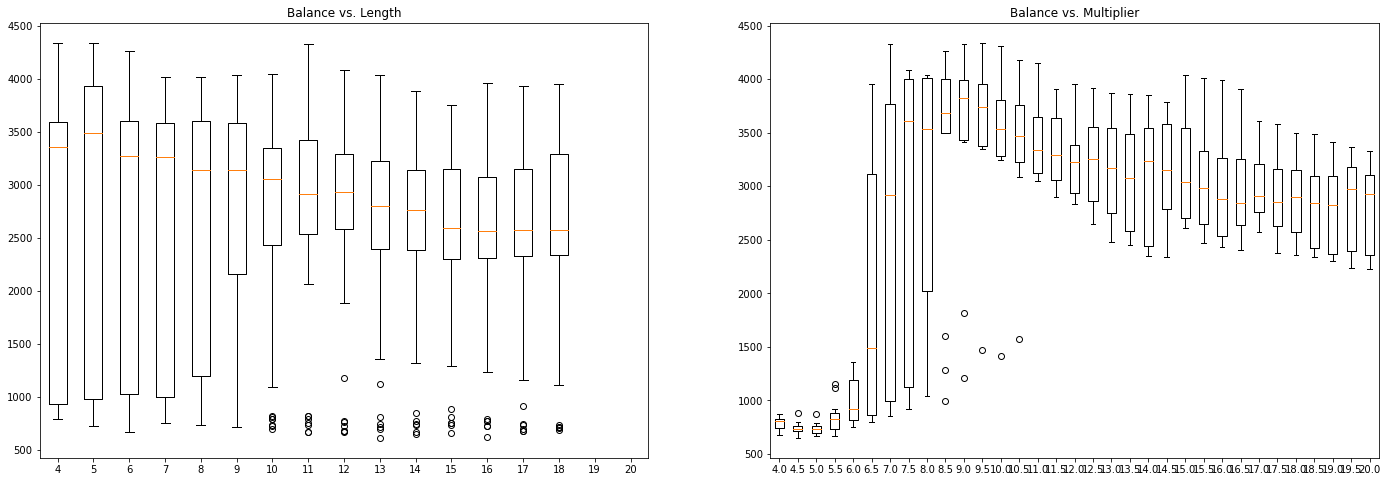

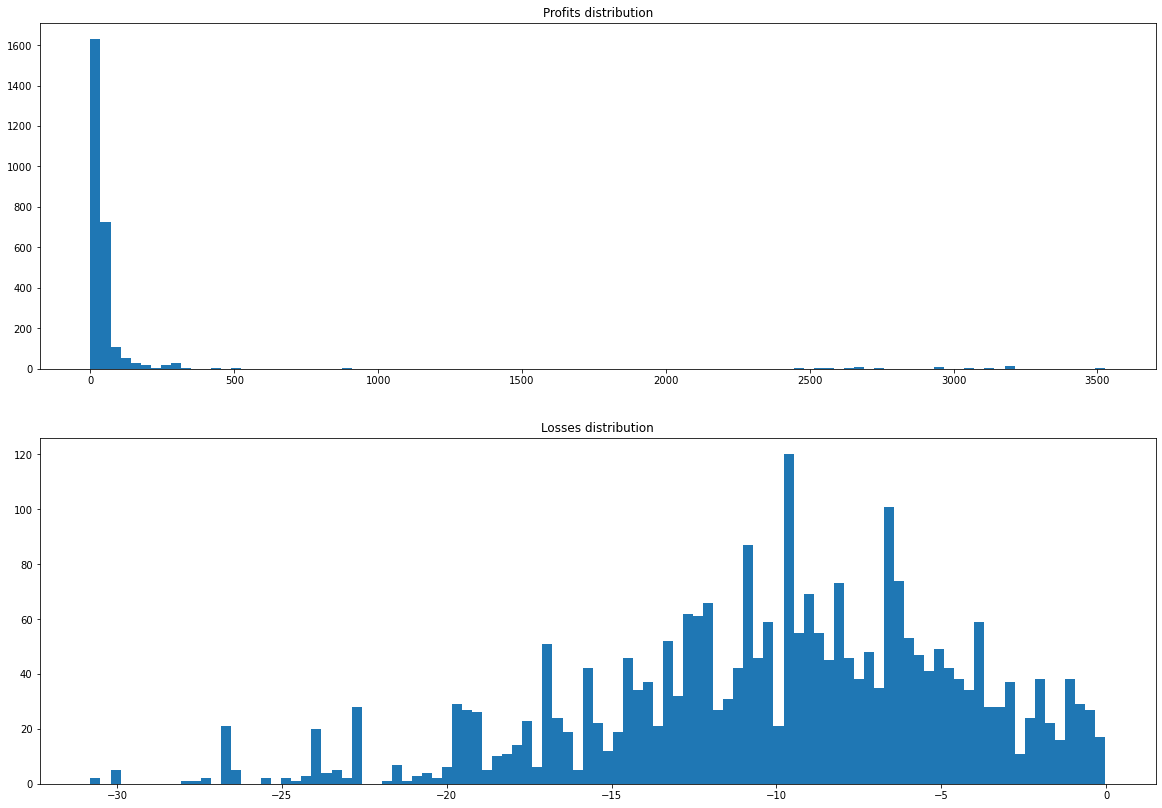

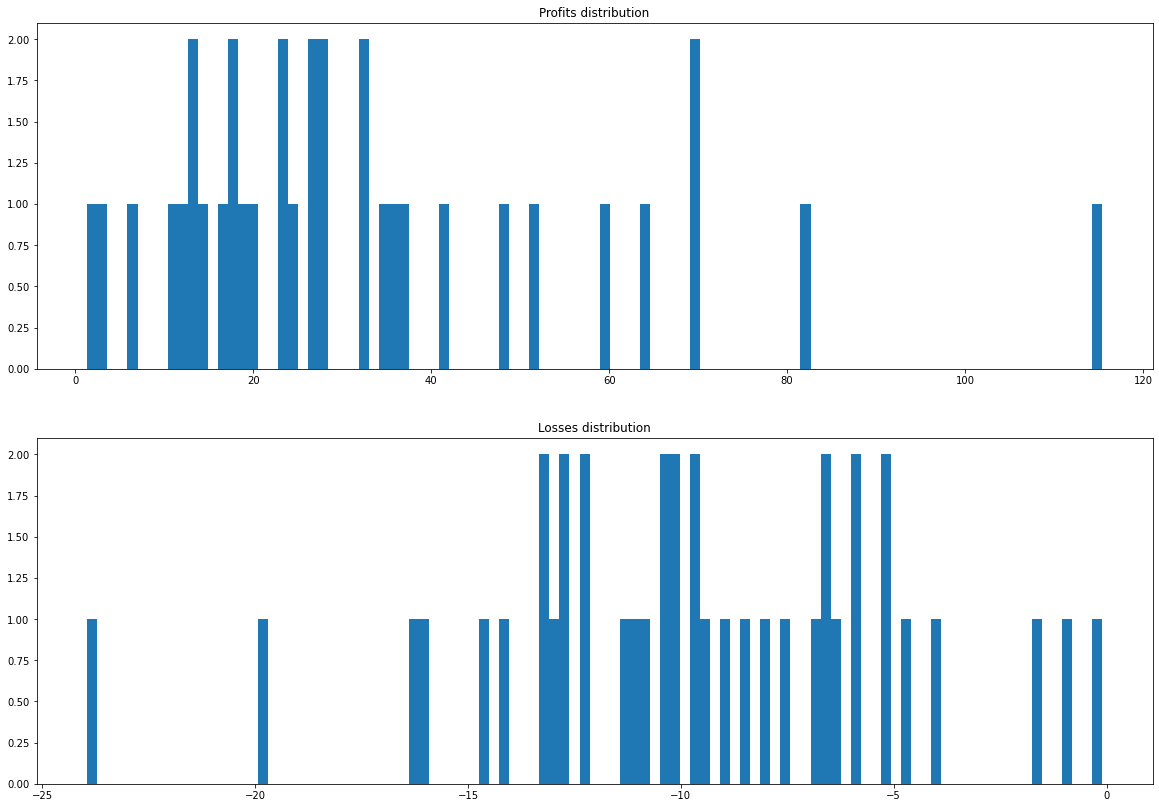

In [ ]:
coin_timeframe = 'eth_4h'
df_btc4h = pandas.read_csv(f"individual_backtest/backtest_summary_{coin_timeframe}.csv")
result = plot1(df_btc4h, coin_timeframe)
save_as_pkl_data(result, f"individual_backtest/goodlist_{coin_timeframe}.pkl")

In [ ]:
coin_timeframes = [  'eth_4h'  ]

for ct in coin_timeframes:
  goodlist = load_pkl_data(ct)
  backtest_summary = pandas.read_csv(f"individual_backtest/backtest_summary_{ct}.csv")
  backtest_summary.sort_values(by='balance', ascending=False, inplace=True)
  # print(backtest_summary.head(10))
  backtest_summary = backtest_summary[  backtest_summary['config_length'].isin(goodlist['good_length_list']) & 
                                        backtest_summary['config_multiplier'].isin(goodlist['good_multiplier_list'])]
  backtest_summary = backtest_summary.iloc[:10,:]
  backtest_summary.to_csv(f"individual_backtest/best_configs_{ct}.csv")
  
  config_list = get_config_list_from_backtest_summary(backtest_summary)
  print(config_list)
  save_as_pkl_data(config_list, f"individual_backtest/config_list_{ct}.pkl")

read_goodlist: {'coin_timeframe': 'eth_4h', 'kinda_best_length': 14, 'kinda_best_multiplier': 5.0, 'good_length_list': array([ 4., 14.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]), 'good_multiplier_list': array([ 4. ,  4.5,  5. ,  5.5,  6. ,  9. ,  9.5, 10.5, 11. , 11.5])}
[[4.0, 9.5], [7.0, 9.0], [6.0, 9.5], [10.0, 9.0], [8.0, 9.0], [6.0, 9.0], [9.0, 9.0], [11.0, 9.0], [9.0, 9.5], [7.0, 9.5]]


In [ ]:
import backtest

coin = 'eth'
timeframes = ('4h',  );  length_in_days = (1/6,)
trends = ('_recentYear',)  #'_bear1', '_bear2', '_bear3', 
result_recorder = backtest.ResultRecorder()

for trend in trends:
  for timeframe, length_in_day in zip(timeframes, length_in_days):
    print('timeframe =', timeframe)
    config_list = load_pkl_data(f"individual_backtest/config_list_{coin}_{timeframe}.pkl")

    df = pandas.read_csv(f"historical_data/{coin}_{timeframe}_original{trend}.csv")
    # Rename columns and drop some to reduce memory weight
    df['timestamp'] = df['time_period_start']
    df['open'] = df['price_open']
    df['high'] = df['price_high']
    df['low'] = df['price_low']
    df['close'] = df['price_close']
    df.drop(['time_period_start', 'time_open', 
            'price_open', 'price_high', 'price_low', 
            'price_close', 'volume_traded', 'trades_count'], axis=1)
    df = df.iloc[::-1].reset_index()
    print('length_of_df =', len(df))

    for (length, multiplier) in config_list:
      length = int(length)
      print(f"config = ({length},{multiplier})")
      supertrend_data, balance = backtest.backtest(length, multiplier, result_recorder, df)
        
      result_recorder.add_new_row({
          'coinpair': coin,
          'timeframe': timeframe,
          'length_in_days': length_in_day*len(supertrend_data), 
          'trend': trend,
          'balance': balance, 
          'config_length': length, 
          'config_multiplier': multiplier, 
          'no_of_orders': result_recorder.order_number, 
          'number_of_profit_order': result_recorder.get_profit_order_number(), 
          'average_profit': result_recorder.get_average_profit(), 
          'number_of_loss_order': result_recorder.get_loss_order_number(), 
          'average_loss': result_recorder.get_average_loss(),
          'avarage_pnl_per_month': balance / (length_in_day*len(supertrend_data)) * 30,
          'profit_amounts': f"\"{result_recorder.get_profit_order()}\"",
          'loss_amounts': f"\"{result_recorder.get_loss_order()}\"",
      })
      ## Save trade history
      result_recorder.save_in_csv(f"individual_backtest/best_configs_backtest_{ct}_2.csv")  #_{length}_{int(multiplier*10)}
      result_recorder.reset_stats()
    print()


timeframe = 4h
length_of_df = 5706 config = (4,9.5)
config = (7,9.0)
config = (6,9.5)
config = (10,9.0)
config = (8,9.0)
config = (6,9.0)
config = (9,9.0)
config = (11,9.0)
config = (9,9.5)
config = (7,9.5)

